In [23]:
import pandas as pd
import numpy as np
import plotly.express as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

pio.templates.default = "plotly_white"

# Matching result import

In [24]:
matched_spectra_df = pd.read_csv("results/matched_spectra_df.csv")
matched_spectra_df['scoring_function'] = matched_spectra_df['scoring_function'].replace('optimize_q_wrapper', 'Andromeda')
matched_spectra_df['scoring_function'] = matched_spectra_df['scoring_function'].replace('simple_scoring_function', 'Simple Scoring')
matched_spectra_df['experiment_name'] = matched_spectra_df['experiment_name'].str.replace('new_', '')
matched_spectra_df.head()


,Unnamed: 0,experiment_name,protein_id,precursor_mass,precursor_mz,mz_array,intensity_array,sequence,peptide_mass,fragments,match_score,scan_id,is_target,scoring_function
0,265627,CTR45_BA46_INSOLUBLE_01,Q92752-2,2216.063415,1109.038984,[ 155.0414851 155.0433163 155.0451474 ... 19...,[ 3031.17358398 5204.18652344 5612.05322266 ...,VGFGNVEDEFWLGLDNIHR,2216.065066,[ 100.07569038 2118.00392892 157.0971541 206...,159.545898,54004,True,Andromeda
1,205776,CTR08_BA46_INSOLUBLE_01,Q16555,2376.183497,1189.099025,[ 168.0583574 168.0604239 168.0624904 168.0...,[ 368.80072021 1290.04040527 2300.48828125 ...,DIGAIAQVHAENGDIIAEEQQR,2376.166965,[ 116.03421949 2262.14729868 229.11828347 214...,159.545898,39356,True,Andromeda
2,261788,CTR45_BA46_INSOLUBLE_01,Q16555,2149.904383,1075.959468,[ 155.3422645 155.3441009 155.3459374 ... 20...,[ 14112.66699219 48678.359375 94077.273437...,FQMPDQGMTSADDFFQGTK,2149.908491,[ 148.07569038 2003.84735382 276.13426789 187...,159.545898,49528,True,Andromeda
3,261615,CTR45_BA46_INSOLUBLE_01,Q16555,2149.908256,1075.961404,[ 155.3418346 155.3436711 155.3455076 ... 20...,[ 852.85089111 1357.58056641 1541.8482666 ......,FQMPDQGMTSADDFFQGTK,2149.908491,[ 148.07569038 2003.84735382 276.13426789 187...,159.545898,49329,True,Andromeda
4,215618,CTR08_BA46_INSOLUBLE_01,Q16555,2149.925062,1075.969808,[ 155.0520131 155.0538444 155.0556757 155.0...,[6.63858643e+02 1.45439624e+03 1.99269617e+03 ...,FQMPDQGMTSADDFFQGTK,2149.908491,[ 148.07569038 2003.84735382 276.13426789 187...,159.545898,50470,True,Andromeda


# FDR calculation

In [25]:
from utils import calculate_fdr
fdr_df = calculate_fdr(matched_spectra_df)
fdr_df.head()

,Unnamed: 0,experiment_name,protein_id,precursor_mass,precursor_mz,mz_array,intensity_array,sequence,peptide_mass,fragments,match_score,scan_id,is_target,scoring_function,cumulative_targets,cumulative_decoys,fdr,score_threshold,achieved_fdr
0,163317,CTR03_BA46_INSOLUBLE_01,P09972,2272.124851,1137.069702,[ 157.0887767 157.0906443 157.0925118 157.0...,[6.01765564e+02 1.59785742e+03 4.56201562e+03 ...,GVVPLAGTDGETTTQGLDGLSER,2272.118284,[ 58.02874019 2216.10409645 157.0971541 211...,159.545898,38356,True,Andromeda,1,0,0.0,44.135151,0.009834
1,172088,CTR03_BA46_INSOLUBLE_01,P09104-2,2701.320481,1351.667517,[ 186.0700293 186.0724368 186.0748443 ... 26...,[1017.04943848 1812.46777344 2114.83935547 ......,DATNVGDEGGFAPNILENSEALELVK,2701.308269,[ 116.03421949 2587.28860275 187.07133328 251...,159.545898,48520,True,Andromeda,2,0,0.0,44.135151,0.009834
2,160792,CTR03_BA46_INSOLUBLE_01,P30086,1948.938425,975.476489,[ 136.069712 136.0712175 136.0727231 136.0...,[ 337.62692261 1016.75518799 1748.67541504 ...,GNDISSGTVLSDYVGSGPPK,1948.937800,[ 58.02874019 1892.92361291 172.07166763 177...,154.774685,35404,True,Andromeda,3,0,0.0,44.135151,0.009834
3,171220,CTR03_BA46_INSOLUBLE_01,P12111-5,2226.099744,743.040524,[ 153.0603278 153.0621239 153.0639201 ... 16...,[ 638.46685791 1251.93847656 1548.97753906 ......,DVVFLIDGSQSAGPEFQYVR,2226.095698,[ 116.03421949 2112.07603123 215.1026334 201...,154.774685,47567,True,Andromeda,4,0,0.0,44.135151,0.009834
4,171274,CTR03_BA46_INSOLUBLE_01,P17174,2233.119230,1117.566892,[ 155.0755184 155.0773501 155.0791819 ... 20...,[ 999.34832764 1811.73571777 2152.11035156 ......,IVASTLSNPELFEEWTGNVK,2233.126664,[ 114.09134044 2121.04987605 213.15975436 202...,154.774685,47626,True,Andromeda,5,0,0.0,44.135151,0.009834


# Pie chart for target database showing identifications for FDR <= 0.01




In [26]:
# =====================================================
# Second set of charts: 2x3 grid with scoring functions as rows and experiments as columns
# =====================================================

# Prepare data for pie charts using cumulative threshold logic (same as before)
results = []
for (experiment, scoring_func), group in fdr_df.groupby(['experiment_name', 'scoring_function']):
    valid_fdr = group[group['fdr'] <= 0.01]
    threshold_idx = valid_fdr.index.max() if not valid_fdr.empty else None

    if threshold_idx is not None:
        passing_targets = int(group.loc[threshold_idx, 'cumulative_targets'])
    else:
        passing_targets = 0

    total_targets = group['is_target'].sum()
    failing_targets = total_targets - passing_targets

    results.append({
        'experiment': experiment,
        'scoring_function': scoring_func,
        'passing': passing_targets,
        'failing': failing_targets
    })

pie_data = pd.DataFrame(results)

# Create subplot grid with original title formatting
scoring_functions = pie_data['scoring_function'].unique()
experiments = pie_data['experiment'].unique()

rows = len(scoring_functions)
cols = len(experiments)

# Create shortened experiment names matching original formatting
def format_experiment_name(name):
    return (name.replace("new_", "")
              .replace("_INSOLUBLE_01", "")
              .replace("_", " "))

# Generate subplot titles matching first chart style
subplot_titles = []
for func in scoring_functions:
    for exp in experiments:
        short_exp = format_experiment_name(exp)
        subplot_titles.append(f"{func}: {short_exp}")

fig2 = make_subplots(
    rows=rows,
    cols=cols,
    specs=[[{'type':'domain'} for _ in range(cols)] for _ in range(rows)],
    subplot_titles=subplot_titles,
    vertical_spacing=0.2,
    horizontal_spacing=0.1  # Increased for better spacing
)

# This stores whether this is the first trace (used for legend)
first_trace = True

for i, scoring_func in enumerate(scoring_functions):
    for j, exp in enumerate(experiments):
        # Get data for this specific combination
        data = pie_data[(pie_data['scoring_function'] == scoring_func) &
                        (pie_data['experiment'] == exp)]

        # Continue even if data is empty - this ensures all subplots are filled
        passing = data['passing'].values[0] if not data.empty else 0
        failing = data['failing'].values[0] if not data.empty else 0

        # Add trace even if both values are zero
        values = [passing, failing]
        if passing == 0 and failing == 0:
            # Set a dummy value to show a full red circle for empty experiments
            values = [0, 1]
            textinfo = 'none'  # Don't show text for empty data
        else:
            textinfo = 'value+percent'

        # For the first trace only, set showlegend=True to create the legend
        # For all other traces, set showlegend=False to avoid duplicate legends
        show_this_legend = first_trace
        first_trace = False

        fig2.add_trace(
            go.Pie(
                labels=['FDR ≤ 0.01', 'FDR > 0.01'],
                values=values,
                textinfo=textinfo,
                marker=dict(
                    colors=['#2ca02c', '#d62728'],
                ),
                hoverinfo='label+percent+value',
                textfont_size=12,
                showlegend=show_this_legend  # Show legend only for first trace
            ),
            row=i+1, col=j+1
        )

fig2.update_layout(
    title={
        'text': "Peptide Identifications by Scoring Function and Experiment (Target Database, FDR <= 0.01)",
        'y':0.98,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20}  # Match font size of first chart
    },
    height=400 * rows,  # Reduced height to match first chart proportions
    width=400 * cols,
    showlegend=True,  # Enable the legend display
    legend=dict(
        orientation="h",  # Horizontal legend
        yanchor="bottom",
        y=-0.1,  # Position below the chart
        xanchor="center",
        x=0.5
    ),
    margin=dict(t=100, b=100),  # Increased bottom margin to accommodate legend
    template="plotly_white"
)

# Adjust title positions to match first chart
for annotation in fig2.layout.annotations:
    annotation.font.size = 14  # Match font size from first chart
    annotation.y += 0.05  # Match the title positioning from first chart

fig2.show()
pio.kaleido.scope.mathjax = None  # Disables MathJax loading issues
fig2.write_image("results/peptide_identifications_by_experiment.pdf")

In [27]:
# =====================================================
# First set of charts: Overall comparison by scoring function (fixed)
# =====================================================

# Reuse the pie_data from the second set of charts
overall_data = pie_data.groupby('scoring_function').agg({
    'passing': 'sum',
    'failing': 'sum'
}).reset_index()

# Create updated figure
fig1 = make_subplots(rows=1, cols=len(scoring_functions),
                    specs=[[{'type':'domain'} for _ in scoring_functions]],
                    subplot_titles=[f"{func}" for func in scoring_functions])

for i, func in enumerate(scoring_functions):
    func_data = overall_data[overall_data['scoring_function'] == func]

    # Get values from pre-calculated data
    passing = func_data['passing'].values[0] if not func_data.empty else 0
    failing = func_data['failing'].values[0] if not func_data.empty else 0

    # Ensure we include even empty data
    if passing == 0 and failing == 0:
        # If there's absolutely no data, show a full red circle
        fig1.add_trace(
            go.Pie(
                labels=['FDR ≤ 0.01', 'FDR > 0.01'],
                values=[0, 1],
                textinfo='none',
                marker=dict(colors=['#2ca02c', '#d62728']),
            ),
            row=1, col=i+1
        )
    else:
        fig1.add_trace(
            go.Pie(
                labels=['FDR ≤ 0.01', 'FDR > 0.01'],
                values=[passing, failing],
                textinfo='value+percent',
                marker=dict(colors=['#2ca02c', '#d62728']),
            ),
            row=1, col=i+1
        )

# Maintain original layout configuration
fig1.update_layout(
    title={
        'text': "Peptide Identifications by Scoring Function (Target Database, FDR <= 0.01)",
        'y':0.98,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20}  # Match font size of first chart
    },
    height=500,
    width=800 * len(scoring_functions) // 2,
    margin=dict(t=120),
    template="plotly_white",
    showlegend=True,  # Enable the legend display
    legend=dict(
        orientation="h",  # Horizontal legend
        yanchor="bottom",
        y=-0.1,  # Position below the chart
        xanchor="center",
        x=0.5
    ),
)

# Adjust title positions
for annotation in fig1.layout.annotations:
    annotation.y += 0.1

fig1.show()
fig1.write_image("results/peptide_identifications_overall.pdf")

# Density plot for match scores

/opt/homebrew/Caskroom/miniconda/base/envs/bmdt_new/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

divide by zero encountered in log2



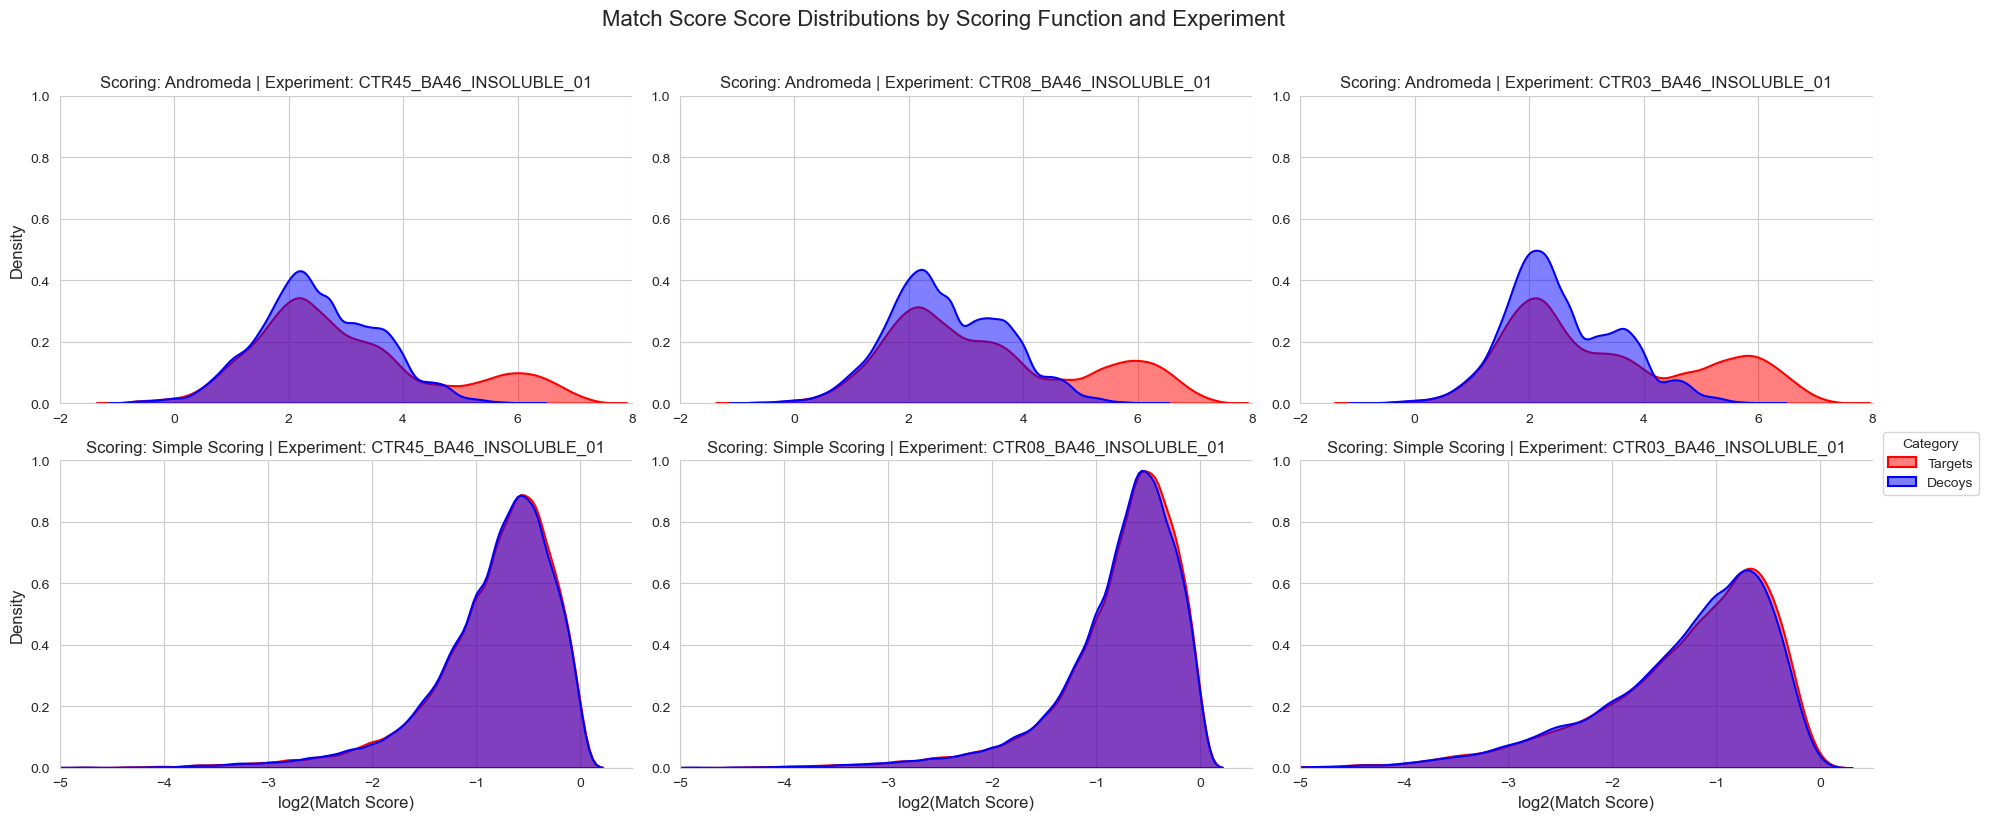

In [32]:
# Density plot for match scores
from visualization import SpectrumVisualizer
import matplotlib.pyplot as plt
total_sv = SpectrumVisualizer(matched_spectra_df)
kde_plot = total_sv.plot_score_distributions("Match Score Score Distributions by Scoring Function and Experiment", custom_xlims={'Andromeda': (-2, 8), 'Simple Scoring': (-5, 0.5)}, custom_ylims={'Andromeda': (0, 1), 'Simple Scoring': (0, 1)})
plt.savefig("results/density_plot.png", dpi=300)


# Bar plots for FDR-calibrated hit counts

In [29]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create shortened experiment names matching original formatting
def format_experiment_name(name):
    return (name.replace("new_", "")
            .replace("_INSOLUBLE_01", "")
            .replace("_", " "))

# Define constants
FDR_THRESHOLDS = [0.01, 0.1, 0.25]
SCORING_FUNCTIONS = ['Andromeda', 'Simple Scoring']
EXPERIMENTS = list(fdr_df['experiment_name'].unique())

# Initialize subplot grid
fig = make_subplots(
    rows=2,
    cols=3,
    subplot_titles=[f"{sf}<br>{format_experiment_name(exp)}" for sf in SCORING_FUNCTIONS for exp in EXPERIMENTS],
    vertical_spacing=0.3,
    horizontal_spacing=0.1,
    specs=[[{"type": "bar"}, {"type": "bar"}, {"type": "bar"}],
           [{"type": "bar"}, {"type": "bar"}, {"type": "bar"}]]
)

# Create mapping for subplot positions
subplot_positions = {
    (sf, exp): (row, col)
    for row, sf in enumerate(SCORING_FUNCTIONS, 1)
    for col, exp in enumerate(EXPERIMENTS, 1)
}

# Process data and create plots
for (scoring_func, experiment), group_df in fdr_df[fdr_df['is_target'] == True].groupby(['scoring_function', 'experiment_name']):
    # Sort by achieved_fdr ascending (best thresholds first)
    sorted_df = group_df.sort_values('fdr', ascending=True)

    # Calculate hits at each FDR threshold
    hit_counts = []
    for threshold in FDR_THRESHOLDS:
        valid = sorted_df[sorted_df['fdr'] <= threshold]
        hit_counts.append(valid['cumulative_targets'].max() if not valid.empty else 0)

    # Get subplot position
    row, col = subplot_positions.get((scoring_func, experiment), (1, 1))

    # Create bar trace
    fig.add_trace(
        go.Bar(
            x=[f'{t*100}%' for t in FDR_THRESHOLDS],
            y=hit_counts,
            name=f'{experiment} - {scoring_func}',
            text=hit_counts,
            textposition='auto'
        ),
        row=row,
        col=col
    )

# Update layout
fig.update_layout(
    template="plotly_white",
    height=800,
    width=1200,
    title={
        "text": "FDR-Calibrated Hit Counts by Experiment and Scoring Function",
        "font": {"size": 24},
        "x": 0.5,
    },
    showlegend=False,
    margin=dict(t=150)
)

# Add axis labels
for row in [1, 2]:
    for col in [1, 2, 3]:
        fig.update_xaxes(title_text="FDR Threshold", row=row, col=col)
        fig.update_yaxes(title_text="Number of Identifications", row=row, col=col)

fig.show()
fig.write_image("results/fdr_calibrated_hit_counts.pdf")